# Hackathon challenge code
## Reinforcement Learning with Projective Simulation for path-finding problems


In this notebook, we provide code to help you start this challenge. The notebook has the following information:
 1. *Grid enviroment*. Here, a class grid is formed according to the given structure.
 2. *Quantum agent*. The agent uses a tree to make the decision and this is translated to quantum optics making use of modes and beam splitters. There, a class for shapping and handling tree is defined. Check the references for more.
 3. *Loss function*. We provide the full loss function already.
 4. *Test*

In [16]:
!python --version

Python 3.10.12


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
!pip install perceval-quandela
import perceval as pcvl

### Grid Environment

Defining a grid given the constraints: size, obstacles, starting point and others. Here, the class "Grid" makes the environment for our problem. The grid is a 2D array of dim $n\times n$, with each element being a cell and defined by a tuple $(x,y)$, where $x$ and $y$ are the coordinates of the cell.

The following methods are defined:
1. \_\_init\_\_(self, n, start, end, n_not_allowed, wall=None, max_steps=None) with arguments:
    * n: the dimension of the grid;
    * start: the starting cell, default is $(0,0)$, bottom left corner;
    * end: the ending cell, default is $(n-1,n-1)$, top right corner;
    * n_not_allowed: the number of cells that are not allowed to be visited, default is $0$, meaning all cells are allowed to be visited, if $n\_not\_allowed > 0$, then $n\_not\_allowed$ cells will be selected and not allowed to be visited;
    * wall: if None, then the $n\_not\_allowed$ cells will be randomly selected, if not None, it should be a list of tuples, each tuple is a cell that is not allowed to be visited;
    * max_steps: the maximum number of steps allowed, default is None, set $2*n$.
2. step(self, action, verbose=False):
    * action: the action taken by the agent, can be right or up;
    * verbose: if True, print out the current state, action, next state, reward, and done;
    * return: the next state, reward, and done.
    *  *next state*: the next cell the agent is in same as the current state if the agent hits the wall or not allowed cell.
    *  *reward*: reward of 0 for each step, +1 for reaching the end.
    *  *done*: True if the agent reaches the end or reaches the max number of steps, False otherwise.
3. reset(self):
    reset the agent to the starting cell and reward to 0 and done to False and step to 0.
4. render(self):
    render the grid, with the agent in the current cell, and the path taken so far.

In [33]:
class Grid():
    def __init__(self, n, start=(0,0), end=None, n_not_allowed=0, wall=None, max_steps=None):
        self.n = n
        self.start = start
        self.end = (n-1,n-1) if end is None else end
        if wall is None and n_not_allowed > 0:
            # generate n_not_allowed random cells
            self.wall = []
            for i in range(n_not_allowed):
                x = np.random.randint(0,n)
                y = np.random.randint(0,n)
                # make sure the random cell is not already in the list or the start or end cell
                while (x,y) in self.wall or (x,y) == self.start or (x,y) == self.end:
                    x = np.random.randint(0,n)
                    y = np.random.randint(0,n)
                self.wall.append((x,y))
        else:
            self.wall = wall
        self.av_states = []
        for i in range(n):
            for j in range(n):
                if not ((i, j) in self.wall or (i, j) == self.end):
                    self.av_states.append((i, j))
        self.max_steps = 2*n if max_steps is None else max_steps
        self.reset()

    def step(self, action, verbose=False):
        wall_flag = False
        if action == 'right':
            next_state = (self.state[0]+1, self.state[1])
        elif action == 'up':
            next_state = (self.state[0], self.state[1]+1) # ADD HERE LEFT AND DOWN ________________________________________
        elif action=='down':
            next_state = (self.state[0], self.state[1]-1)
        elif action == 'left':
            next_state = (self.state[0]-1, self.state[1])
        else:
            raise ValueError('action must be right, up, left or down')
        if next_state[1] >= self.n or next_state[0] >= self.n or next_state[1] < 0 or next_state[0] < 0:
            next_state = self.state
            wall_flag = True
        elif next_state in self.wall:
            next_state = self.state
            wall_flag = True
        total_state = self.state
        self.state = next_state
        self.step_count += 1
        if self.state == self.end:
            reward = 10
            self.done = True
        elif self.step_count >= self.max_steps:
            reward = -1
            self.done = True
        else:
            reward= 0 if not wall_flag else -20
            self.done = False
        self.total_path.append(self.state)
        self.path_actions.append(action)
        if verbose:
            print('state: {}, action: {}, next_state: {}, reward: {}, done: {}'.format(total_state, action, next_state, reward, self.done))
        return next_state, reward, self.done

    def reset(self):
        self.state = self.start
        self.step_count = 0
        self.reward = 0
        self.done = False
        self.total_path = []
        self.total_path.append(self.state)
        self.path_actions = []

    def render(self, path=None):
        grid = np.zeros((self.n,self.n))
        for i in range(self.n):
            for j in range(self.n):
                if (i,j) in self.wall:
                    grid[j,i] = -1
        grid[self.start[1],self.start[0]] = 0.25
        grid[self.end[1],self.end[0]] = 0.25
        if path is None:
            path = self.total_path
            state = self.state
        else:
            state = path[-1]
        grid[state[1],state[0]] = 1
        for i in range(len(path)-1)[1:]:
            grid[path[i][1],path[i][0]] = 0.5
        # grid is upside down, so flip it both horizontally and vertically
        grid = np.flip(grid, axis=0)
        # transpose it
        #grid = np.transpose(grid)
        plt.imshow(grid, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

Giving it a test for a given wall and plotting it. The number of steps here is set to $9$. Adjust it to the needs of your algorithm.

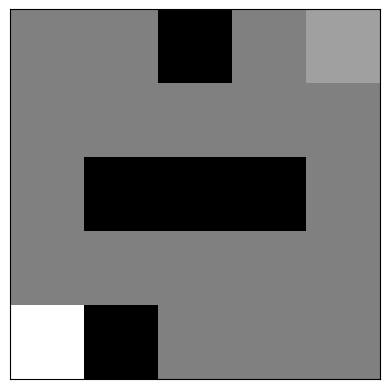

In [36]:
first_wall = [(1, 2), (2, 2), (1, 0), (3, 2), (2, 4)]
# test trial of the env with random agent
env = Grid(5, n_not_allowed=5, wall=first_wall, max_steps=9)
env.render()

Testing a random path.

In [37]:
for i in range(50):
    action = random.choice(['right','up','left','down'])
    next_state, reward, done = env.step(action, verbose=True)
    if done:
        break

state: (0, 0), action: down, next_state: (0, 0), reward: -20, done: False
state: (0, 0), action: right, next_state: (0, 0), reward: -20, done: False
state: (0, 0), action: down, next_state: (0, 0), reward: -20, done: False
state: (0, 0), action: up, next_state: (0, 1), reward: 0, done: False
state: (0, 1), action: up, next_state: (0, 2), reward: 0, done: False
state: (0, 2), action: right, next_state: (0, 2), reward: -20, done: False
state: (0, 2), action: right, next_state: (0, 2), reward: -20, done: False
state: (0, 2), action: left, next_state: (0, 2), reward: -20, done: False
state: (0, 2), action: right, next_state: (0, 2), reward: -1, done: True


In [38]:
# Create an instance of the Grid class with desired parameters
grid_instance = Grid(n=5, start=(0, 0), end=(4, 4), n_not_allowed=5)

# Iterate over all cells in the grid
for i in range(grid_instance.n):
    for j in range(grid_instance.n):
        if (i, j) == grid_instance.start:
            print(f"Cell at position ({i}, {j}): Start")
        elif (i, j) == grid_instance.end:
            print(f"Cell at position ({i}, {j}): End")
        elif (i, j) in grid_instance.wall:
            print(f"Cell at position ({i}, {j}): Wall")
        else:
            print(f"Cell at position ({i}, {j}): Empty")

# Perform an action (e.g., move right)
action = 'right'
next_state, reward, done = grid_instance.step(action)

# Print the reward received
print("Reward received:", reward)



Cell at position (0, 0): Start
Cell at position (0, 1): Empty
Cell at position (0, 2): Empty
Cell at position (0, 3): Empty
Cell at position (0, 4): Wall
Cell at position (1, 0): Empty
Cell at position (1, 1): Empty
Cell at position (1, 2): Empty
Cell at position (1, 3): Empty
Cell at position (1, 4): Empty
Cell at position (2, 0): Empty
Cell at position (2, 1): Empty
Cell at position (2, 2): Empty
Cell at position (2, 3): Wall
Cell at position (2, 4): Empty
Cell at position (3, 0): Wall
Cell at position (3, 1): Empty
Cell at position (3, 2): Empty
Cell at position (3, 3): Empty
Cell at position (3, 4): Empty
Cell at position (4, 0): Empty
Cell at position (4, 1): Wall
Cell at position (4, 2): Empty
Cell at position (4, 3): Wall
Cell at position (4, 4): End
Reward received: 0


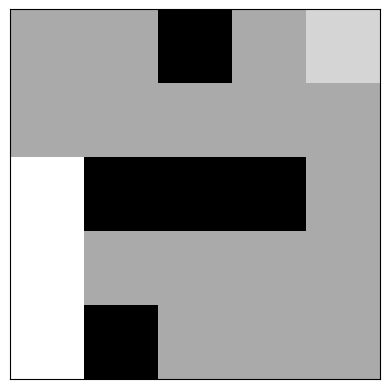

In [40]:
env.render()
#env.total_path
#env.path_actions

### Quantum agent

Here the tree for the ECM graph is created to implement the quantum part of the algorithm.

In [ ]:
import perceval as pcvl
from perceval.algorithm import Sampler
from perceval.components.unitary_components import PS, BS

## Use the symbolic skin for display
from perceval.rendering.circuit import DisplayConfig, SymbSkin
DisplayConfig.select_skin(SymbSkin)

import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm #python library that displays the progress bar
import random

In [ ]:

mzi = pcvl.Circuit(2) // BS() // (1,PS(phi=pcvl.P("phi"))) // BS()
pcvl.pdisplay(mzi)

In [ ]:
circuit = pcvl.Circuit(4)
circuit.add((1,2),BS()).add(2,PS(phi=pcvl.P("phi_11"))).add((1,2),BS())
circuit.add((0,1),BS()).add(1,PS(phi=pcvl.P("phi_21"))).add((0,1),BS())
circuit.add((2,3),BS()).add(3,PS(phi=pcvl.P("phi_22"))).add((2,3),BS())


pcvl.pdisplay(circuit)


In [ ]:
        circuit = pcvl.Circuit(4)
        circuit.add((1,2),BS()).add(1,PS(phi=pcvl.P("phi_11"))).add((1,2),BS()).add(1,PS(phi=pcvl.P("phi_12")))
        circuit.add((0,1),BS()).add(0,PS(phi=pcvl.P("phi_21"))).add((0,1),BS()).add(0,PS(phi=pcvl.P("phi_22")))
        circuit.add((2,3),BS()).add(2,PS(phi=pcvl.P("phi_31"))).add((2,3),BS()).add(2,PS(phi=pcvl.P("phi_32")))

        pcvl.pdisplay(circuit)

In [ ]:
        circuit = pcvl.Circuit(2)
        circuit.add((0,1),BS()).add(0,PS(phi=pcvl.P("phi_1"))).add((0,1),BS()).add(0,PS(phi=pcvl.P("phi_2")))

pcvl.pdisplay(circuit)

In [ ]:
circuit = pcvl.Circuit(2)
circuit.add((0,1),BS()).add(1,PS(phi=pcvl.P("phi_11"))).add((0,1),BS())
pcvl.pdisplay(circuit)


In [ ]:
circuit //=((1,2),BS()).add(2,PS(phi=pcvl.P("phi_11"))).add((1,2),BS())

In [ ]:
n=8 #Number of decisions= n_edge_grid - 1
circuit = pcvl.Circuit(n)
for i in range(n)
    circuit.add((1,2),BS()).add(2,PS(phi=pcvl.P("phi_11"))).add((1,2),BS())


In [ ]:
# TASK 1´
class Tree():
    def __init__(self, n_leaves=4, remote=False,
            remote_config={
                'processor': 'sim:ascella',
                'token': None,
                'nshots': 1e5}):

        self.n_leaves = n_leaves
        self.layers=int(self.n_leaves/2)

        # create the tree


        self.circuit = pcvl.Circuit(2)
        self.circuit.add((0,1),BS()).add(0,PS(phi=pcvl.P("phi_1"))).add((0,1),BS()).add(0,PS(phi=pcvl.P("phi_2")))

        for p in self.circuit.get_parameters():
             p.set_value(np.pi/4)

        # Suggestion: create the indeces for where you should place the LO components
        #             add the component to each branch of the tree
        # ....

        # initialize parameters. This here is kind of random, we suggest initializing them as np.pi/4
        # ....

        # input state
        in_list = [0]*(self.n_leaves)
        in_list[self.layers-1] = 1
        self.in_state = pcvl.BasicState(in_list)

        # flag for remote computation
        self.remote = remote
        if self.remote:
            pass# configure the remote params
            # ....
        else:
            # processor
            self.processor = pcvl.Processor('SLOS',self.circuit)

        self.processor.with_input(self.in_state)
        self.sampler=pcvl.algorithm.Sampler(self.processor)

        self.probs = self.compute_pdf()

    # post selection function to discard 2 photon events due to g2
    def g2_postselect_func(self, s: pcvl.BasicState) -> bool:
        counts = np.sum([n for n in s])
        if counts !=1:
            return False
        return True

     # take perceval state and return the index of the mode with 1
    def stateToModeIdx(self, state):
        state_str = str(state)
        state_str = state_str.replace("|", "")
        state_str = state_str.replace(">", "")
        state_str = state_str.split(",")
        return state_str.index("1")

    # perform single photon walk
    def sample(self):
        return np.random.choice(list(self.probs.keys()), p=list(self.probs.values()))

    def compute_pdf(self):
        if self.remote:

            pass# ....

            # postselect
            results['results'] = {k: v for k, v in results['results'].items() if self.g2_postselect_func(k)}
            tot_samples = np.sum([v for v in results['results'].values()])
            probs = {k: v/tot_samples for k, v in results['results'].items()}
        else:
            probs = self.sampler.probs()["results"]
        probs = {self.stateToModeIdx(state): prob for state, prob in probs.items()}
        return probs

    def pdf(self):
        return self.probs

    def updateCircuit(self, new_params):

        for i,p in enumerate(self.circuit.get_parameters()):
          p.set_value(new_params[i])

        # update the processor
        if self.remote:
            self.processor.set_circuit(self.circuit)
        else:
            self.processor = pcvl.Processor("SLOS", self.circuit)
            self.processor.with_input(self.in_state)

        self.sampler = Sampler(self.processor)
        self.probs = self.compute_pdf()

In [48]:
#TASK 2

class Tree():
    def __init__(self, n_leaves=4, remote=False,
            remote_config={
                'processor': 'sim:ascella',
                'token': None,
                'nshots': 1e5}):

        self.n_leaves = n_leaves
        self.layers=int(self.n_leaves/2)

        # create the tree


        self.circuit = pcvl.Circuit(4)
        self.circuit.add((1,2),BS()).add(1,PS(phi=pcvl.P("phi_11"))).add((1,2),BS()).add(1,PS(phi=pcvl.P("phi_12")))
        self.circuit.add((0,1),BS()).add(0,PS(phi=pcvl.P("phi_21"))).add((0,1),BS()).add(0,PS(phi=pcvl.P("phi_22")))
        self.circuit.add((2,3),BS()).add(2,PS(phi=pcvl.P("phi_31"))).add((2,3),BS()).add(2,PS(phi=pcvl.P("phi_32")))

        for p in self.circuit.get_parameters():
             p.set_value(np.pi/4)

        # Suggestion: create the indeces for where you should place the LO components
        #             add the component to each branch of the tree
        # ....

        # initialize parameters. This here is kind of random, we suggest initializing them as np.pi/4
        # ....

        # input state

        self.in_state = pcvl.BasicState([0,0,1,0])

        # flag for remote computation
        self.remote = remote
        if self.remote:
            pass# configure the remote params
            # ....
        else:
            # processor
            self.processor = pcvl.Processor('SLOS',self.circuit)

        self.processor.with_input(self.in_state)
        self.sampler=pcvl.algorithm.Sampler(self.processor)

        self.probs = self.compute_pdf()

    # post selection function to discard 2 photon events due to g2
    def g2_postselect_func(self, s: pcvl.BasicState) -> bool:
        counts = np.sum([n for n in s])
        if counts !=1:
            return False
        return True

     # take perceval state and return the index of the mode with 1
    def stateToModeIdx(self, state):
        state_str = str(state)
        state_str = state_str.replace("|", "")
        state_str = state_str.replace(">", "")
        state_str = state_str.split(",")
        return state_str.index("1")

    # perform single photon walk
    def sample(self):
        return np.random.choice(list(self.probs.keys()), p=list(self.probs.values()))

    def compute_pdf(self):
        if self.remote:

            pass# ....

            # postselect
            results['results'] = {k: v for k, v in results['results'].items() if self.g2_postselect_func(k)}
            tot_samples = np.sum([v for v in results['results'].values()])
            probs = {k: v/tot_samples for k, v in results['results'].items()}
        else:
            probs = self.sampler.probs()["results"]
        probs = {self.stateToModeIdx(state): prob for state, prob in probs.items()}
        return probs

    def pdf(self):
        return self.probs

    def updateCircuit(self, new_params):

        for i,p in enumerate(self.circuit.get_parameters()):
          p.set_value(new_params[i])

        # update the processor
        if self.remote:
            self.processor.set_circuit(self.circuit)
        else:
            self.processor = pcvl.Processor("SLOS", self.circuit)
            self.processor.with_input(self.in_state)

        self.sampler = Sampler(self.processor)
        self.probs = self.compute_pdf()

Give it a test. A tree with two leaves, this is two options for movement, should output the following cells.

In [49]:
# tree with SLOS
tree = Tree(6)
tree.updateCircuit([np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2])
tree.pdf()

{0: 0.24999999999999994, 1: 0.25, 2: 0.25, 3: 0.25}

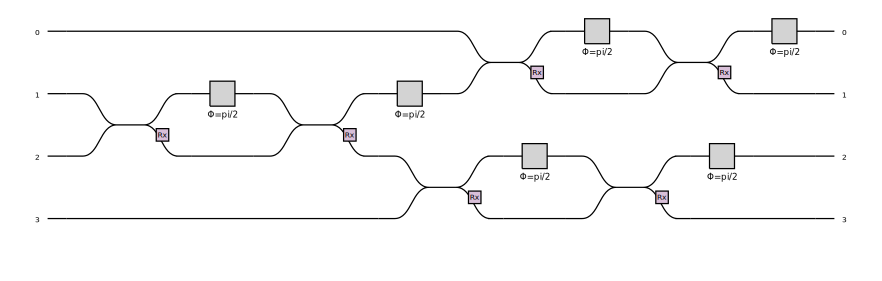

In [50]:
pcvl.pdisplay(tree.circuit)

### Loss function

The loss function is fully implemented here and, in principle, you don't need to change anything even when adding constraints for bonus points. You can use it directly, no changes needed.

For details on how it is constructed, check the references from the challenge file.

In [59]:
 # initialize vector delta_k to a bernoulli +-1 distribution of size n_params
def bernoulli_delta(n_params, p=0.5):
    delta_k = np.random.binomial(1, p, n_params)
    delta_k[delta_k==0] = -1
    return delta_k

In [76]:
def phase_loss(tree):
    u = np.array(tree.circuit.compute_unitary())
    input = np.array([3, 2, 1, 0])
    output = np.dot(u, input)
    out_phases = np.angle(output)
    return np.sum(np.abs(out_phases))

In [77]:
def tree_loss(params, probs, actions, rewards, c=0.1, delta_k = None, log=False):

    # shift params
    if delta_k is not None:
        tree.updateCircuit(params+c*delta_k)
        """
        for i, p in enumerate(tree.circuit.get_parameters()):
            p.set_value(params[i]+c*delta_k[i])
        """
    pdf_dict = tree.pdf()
    next_probs = np.array([pdf_dict[action] for action in actions])
    # compute the expected next step probabilities given the reward
    relu = lambda x: np.maximum(x, 0)
    expected_probs = 1-relu(1-relu(rewards + probs))
    # compute the loss with KL divergence of both (next_probs, expected_probs) and (1-next_probs, 1-expected_probs) since the two are not normalized
    # regularization is added to avoid Nan values
    regHigh = 1+1e-5
    regLow = 1e-5
    loss = np.sum(next_probs*np.log((next_probs+regLow)/(expected_probs+regLow))+ (1-next_probs)*np.log((regHigh-next_probs)/(regHigh-expected_probs)))
    # add shannon loss
    if log:
        return loss, phase_loss(tree)
    loss += phase_loss(tree)
    return loss

In [78]:
def middle_spsa_step(params, loss_fun, tree, actions, rewards, delta_k, c=0.1):
    grads = []
    # compute loss for positive and negative perturbation
    # current probs
    pdf_dict = tree.pdf()
    probs = np.array([pdf_dict[action] for action in actions])
    loss_plus = loss_fun(params, probs, actions, rewards, c, delta_k)
    loss_minus = loss_fun(params, probs, actions, rewards, -c, delta_k)
    for i in range(len(params)):
        grads.append((loss_plus-loss_minus)/(2*c*delta_k[i]))
    return grads

#### Combining the grid, circuit and loss function to train the model

Here is where everything comes together to train our agent.
Let's start with the grid. Try to test your circuit implementation with the following grid. You can use a simpler one, specially when testing constraints.

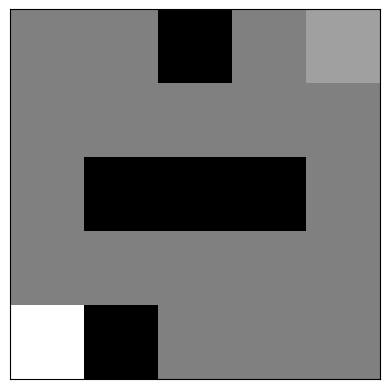

In [79]:
grid_5x5 = Grid(5, n_not_allowed=5, wall=first_wall, max_steps=15)
grid_5x5.render()

Defining "tree_params". It starts with some probability for the choices for each state. The goal is to make it learn and update these parameters based on the rewards.

In [80]:
tree_params = {
    # is a dict with an empy list for each position tuple in the grid excluded final state and walls
    state: [np.pi/2]*len(tree.circuit.get_parameters()) for state in grid_5x5.av_states
}

In [81]:
key_to_action = {
    0: 'right',
    1: 'up',
    2: 'left',
    3: 'down'}
action_to_key = {
    'right': 0,
    'up': 1,
    'left' :2,
    'down' :3}

The cell that does the magic :D

Here, the training happens!

In [110]:
n_episodes = 200
score = []
paths = []
good_path=[]
counter = 0
for i in tqdm(range(n_episodes)):
    lr = 0.1
    # reset grid
    grid_5x5.reset()
    rewards = []
    actions = []
    while not grid_5x5.done:
        state = grid_5x5.state          # get current state
        params = tree_params[state]     # get current params
        tree.updateCircuit(params)      # update tree
        # sample action
        action = key_to_action[tree.sample()]
        next_state, reward, done = grid_5x5.step(action)
        rewards.append(reward/10)       # save reward
    # compute gradients for each position seen
    #print(grid_5x5.state, rewards[-1]) # print final state and final reward
    actions = [action_to_key[action] for action in grid_5x5.path_actions]

    if grid_5x5.state == grid_5x5.end:
        counter += 1
        good_path.append(i)
    for i, state in enumerate(grid_5x5.total_path[:-1]):
        params = tree_params[state]
        delta_k = bernoulli_delta(len(params))
        tree.updateCircuit(params)
        # compute distance last state to end
        dist_to_end = np.linalg.norm(np.array(state)-np.array(grid_5x5.end))
        reg = 1e-5
        grads = middle_spsa_step(params, tree_loss, tree, [actions[i]], [(rewards[-1] + rewards[i])/(dist_to_end+reg)], delta_k)
        # update params
        tree_params[state] = [p-lr*g for p, g in zip(params, grads)]
        tree.updateCircuit(tree_params[state])

    score.append(np.linalg.norm(np.array(grid_5x5.total_path[-1])-np.array(grid_5x5.end)))

    paths.append(grid_5x5.total_path)   # save path

  0%|          | 0/200 [00:00<?, ?it/s]

In [112]:
good_path

[1, 10, 74, 127]

You can see the probabilities of selecting each action for each cell of the grid (we printed it) or you can also plot the path (commented part).

In [118]:
# print each tree key and pdf
for key, params in tree_params.items():
    tree.updateCircuit(params)
    print(key, tree.pdf())

# find index where path not completed
#for i, path in enumerate(paths):
#    if len(path) < 10:
#        print(i, path)

(0, 0) {0: 0.058609847424252785, 1: 0.7451160490746916, 2: 0.008698054481641496, 3: 0.1875760490194141}
(0, 1) {0: 0.19088715588534946, 1: 0.5827115057879869, 2: 0.22451624001732537, 3: 0.0018850983093382566}
(0, 2) {0: 0.0026052039473127447, 1: 0.811853646179261, 2: 0.07846845608016226, 3: 0.10707269379326392}
(0, 3) {0: 0.685221202791253, 1: 0.311468859075815, 2: 0.003207062079685345, 3: 0.00010287605324660452}
(0, 4) {0: 0.004639166852202773, 1: 0.01215574134855474, 2: 0.05378727314028371, 3: 0.9294178186589588}
(1, 1) {0: 0.24479453239155388, 1: 0.594432147232991, 2: 0.00934146725966497, 3: 0.15143185311579016}
(1, 3) {0: 0.0017792399752739984, 1: 0.0006779559892278468, 2: 0.9407133703245574, 3: 0.056829433710940694}
(1, 4) {0: 0.4192499484528779, 1: 0.0853064309458701, 2: 0.45819753456072515, 3: 0.03724608604052676}
(2, 0) {0: 0.03544278688067375, 1: 0.8952865375077473, 2: 0.04457410902090553, 3: 0.024696566590673437}
(2, 1) {0: 0.016341143550363417, 1: 0.030371521852525358, 2: 0.

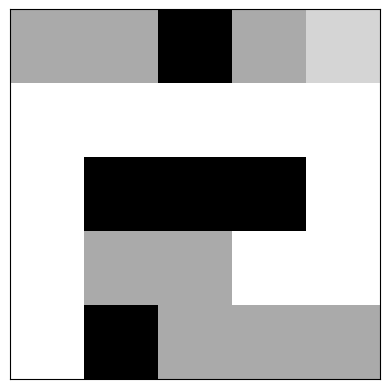

In [119]:
# visualization after selecting a good path.
grid_5x5.render(paths[2])